In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation


In [2]:
def read_from_file(path):
    f = open(path, "r")
    strings = f.readlines()
    return (np.array([s.split() for s in strings]).astype(float))

def deriv(Xip):
    xip1 = Xip[0]
    yip1 = Xip[2]
    return np.array([[xip1 / (xip1 ** 2 + yip1 ** 2) ** 0.5, 0, yip1 / (xip1 ** 2 + yip1 ** 2) ** 0.5, 0],
                     [yip1 / (xip1 ** 2 + yip1 ** 2)       , 0, -xip1 / (xip1 ** 2 + yip1 ** 2)      , 0]])

def h(X):
    x = X[0]
    y = X[2]
    return np.array([(x ** 2 + y ** 2) ** 0.5, np.arctan(x / y)])

def generate_D(x, y):
    D = np.zeros([len(x), 2])
    for i in range(len(x)):
        D[i, 0] = (x[i] ** 2 + y[i] ** 2) ** 0.5
        D[i, 1] = np.arctan(x[i] / y[i])
    return D

def kalman_filt(z, X0, P0, F, Q, R):
    Xf = np.zeros([len(z), len(P0)])
    Xp = np.zeros([len(z), len(P0)])
    Pf = np.zeros([len(z), len(P0), len(P0)])
    Pp = np.zeros([len(z), len(P0), len(P0)])
    K = np.zeros([len(z), len(P0), len(z[0])])
    Xf[0] = X0
    Xp[0] = X0
    Pf[0] = P0
    Pp[0] = P0
    for i in range(len(z) - 1):
        Xp[i + 1] = F.dot(Xf[i])
        Pp[i + 1] = (F.dot(Pf[i])).dot(F.T) + Q
        
        K[i + 1] = (Pp[i + 1].dot(deriv(Xp[i + 1]).T)).dot(np.linalg.inv((deriv(Xp[i + 1]).dot(Pp[i + 1])).dot(deriv(Xp[i + 1]).T) + R))
        
        Xf[i + 1] = Xp[i + 1] + K[i + 1].dot(z[i + 1] - h(Xp[i + 1]))
        Pf[i + 1] = (np.identity(len(P0)) - K[i + 1].dot(deriv(Xp[i + 1]))).dot(Pp[i + 1])
        
    return Xf, generate_D(Xf[:, 0], Xf[:, 2]), generate_D(Xp[:, 0], Xp[:, 2]), Pf, Pp, K

def backward_smooth(Xf, F, Pf, Pp):
    x = np.array(Xf)
    Pn = np.array(Pf)
    A = np.zeros([len(Xf), len(Pf[0]), len(Pf[0])])
    for i in range(len(x) - 2, -1, -1):
        A[i] = (Pf[i].dot(F.transpose())).dot(np.linalg.inv(Pp[i]))
        x[i] = Xf[i] + A[i].dot(x[i + 1] - F.dot(Xf[i]))
        Pn[i] = Pf[i] + (A[i].dot(Pn[i + 1] - Pp[i])).dot(A[i].transpose())
    
    return x, generate_D(x[:, 0], x[:, 2]), Pn

In [3]:
data_temp = read_from_file("/Users/vladimirberman/Downloads/data/z1.txt")
data_temp = np.append(data_temp, read_from_file("/Users/vladimirberman/Downloads/data/z2.txt"), axis=1)
data_temp = np.append(data_temp, read_from_file("/Users/vladimirberman/Downloads/data/z3.txt"), axis=1)

In [4]:
data = np.zeros([len(data_temp[0]) // 2, len(data_temp[:, 0]), 2])

data[0][:, 0] = data_temp[:, 0]
data[0][:, 1] = data_temp[:, 1]
data[1][:, 0] = data_temp[:, 2]
data[1][:, 1] = data_temp[:, 3]
data[2][:, 0] = data_temp[:, 4]
data[2][:, 1] = data_temp[:, 5]

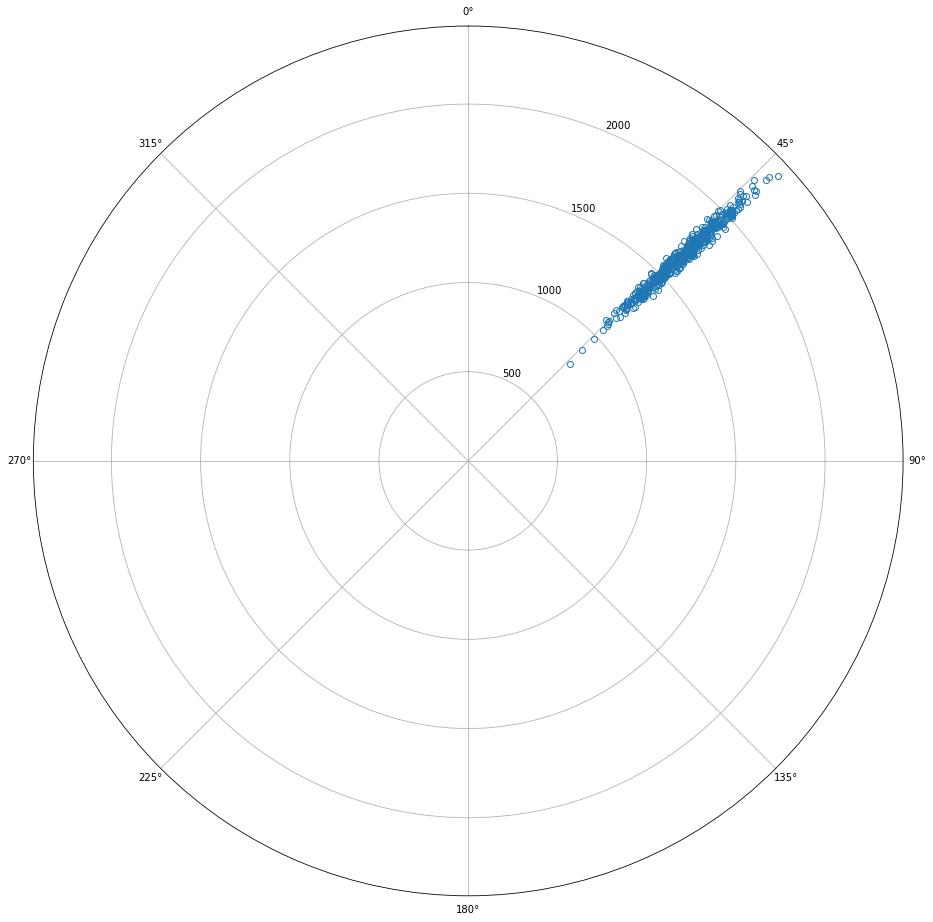

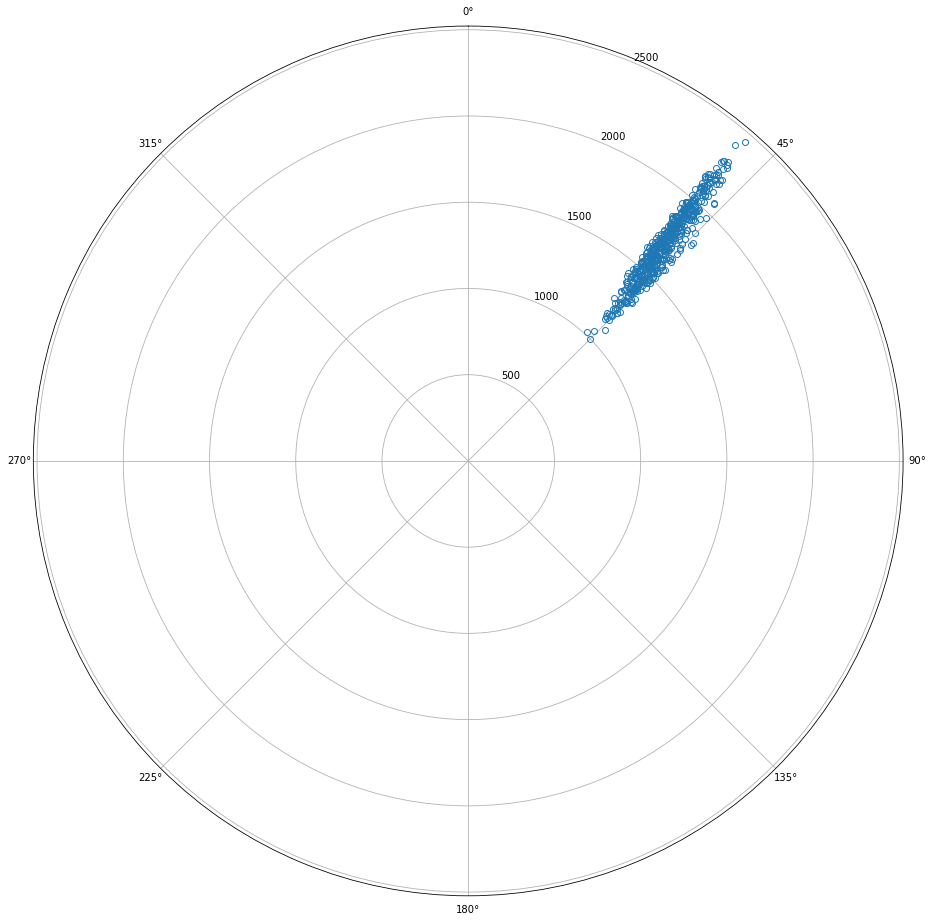

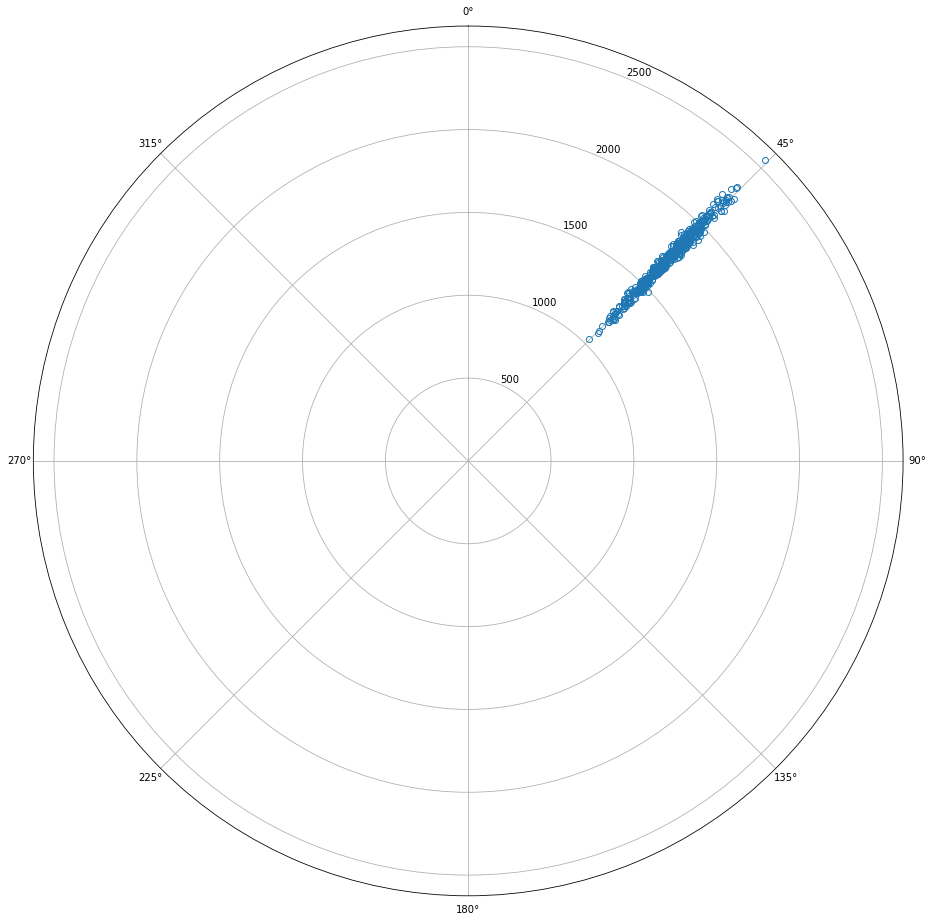

In [5]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

plt.plot(data[0][:, 1], data[0][:, 0], 'o', mfc='none')

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

plt.plot(data[1][:, 1], data[1][:, 0], 'o', mfc='none')

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

plt.polar(data[2][:, 1], data[2][:, 0], 'o', mfc='none')

In [6]:
T = 1

sigma_D_2 = 200 ** 2
sigma_b_2 = 0.01 ** 2

sigma_eta_D = sigma_D_2 ** 0.5
sigma_eta_b = sigma_b_2 ** 0.5

sigmaa_2 = 0.01 ** 2

X0 = np.array([[data[0, 0, 0] * np.sin(data[0, 0, 1]), 0, data[0, 0, 0] * np.cos(data[0, 0, 1]), 0],
               [data[1, 0, 0] * np.sin(data[1, 0, 1]), 0, data[1, 0, 0] * np.cos(data[1, 0, 1]), 0],
               [data[2, 0, 0] * np.sin(data[2, 0, 1]), 0, data[2, 0, 0] * np.cos(data[2, 0, 1]), 0]])
P0 = np.array([[10 ** 4, 0, 0, 0],
               [0, 10 ** 4, 0, 0],
               [0, 0, 10 ** 4, 0],
               [0, 0, 0, 10 ** 4]])

In [7]:
F = np.array([[1, T, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, T],
              [0, 0, 0, 1]])

G = np.array([[T ** 2 / 2, 0],
              [T,          0],
              [0, T ** 2 / 2],
              [0,          T]])
Q = (G.dot(G.transpose())).dot(sigmaa_2)

R = np.array([[sigma_D_2, 0],
              [0, sigma_b_2]])

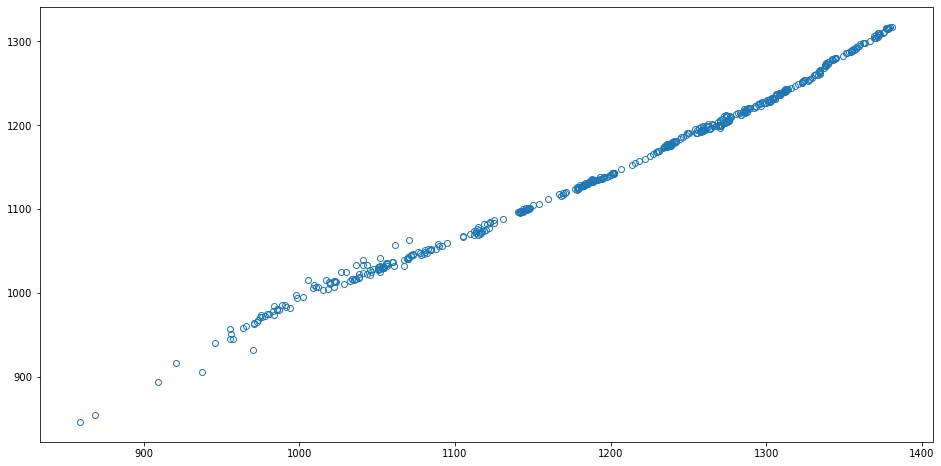

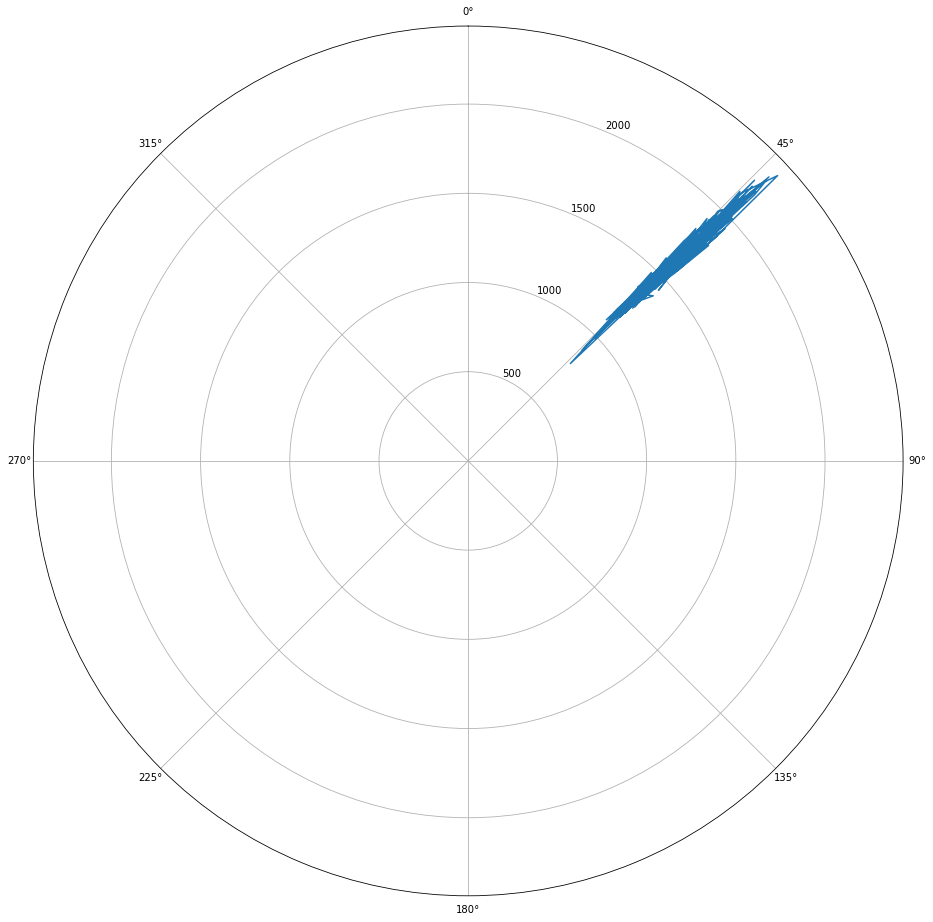

In [8]:
X_f0 = kalman_filt(data[0], X0[0], P0, F, Q, R)
plt.figure(figsize = (16, 8))
plt.plot(X_f0[0][:, 0], X_f0[0][:, 2], 'o', mfc='none')

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

plt.plot(data[0][:, 1], data[0][:, 0])

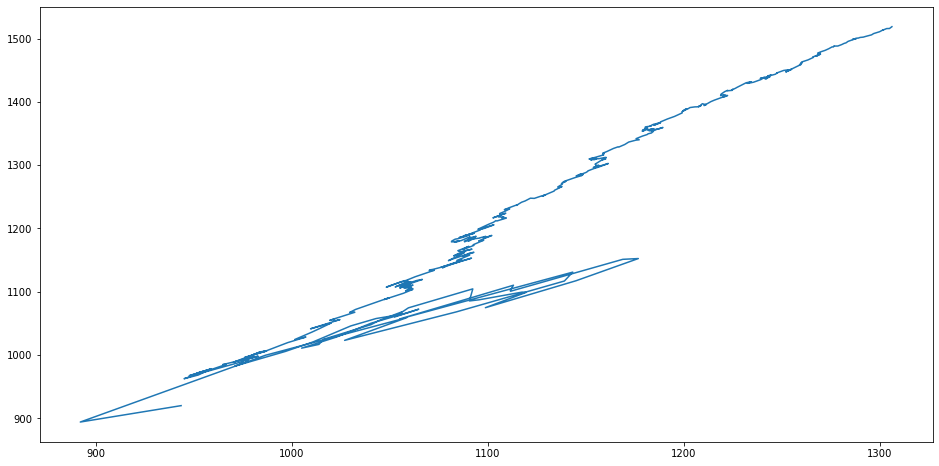

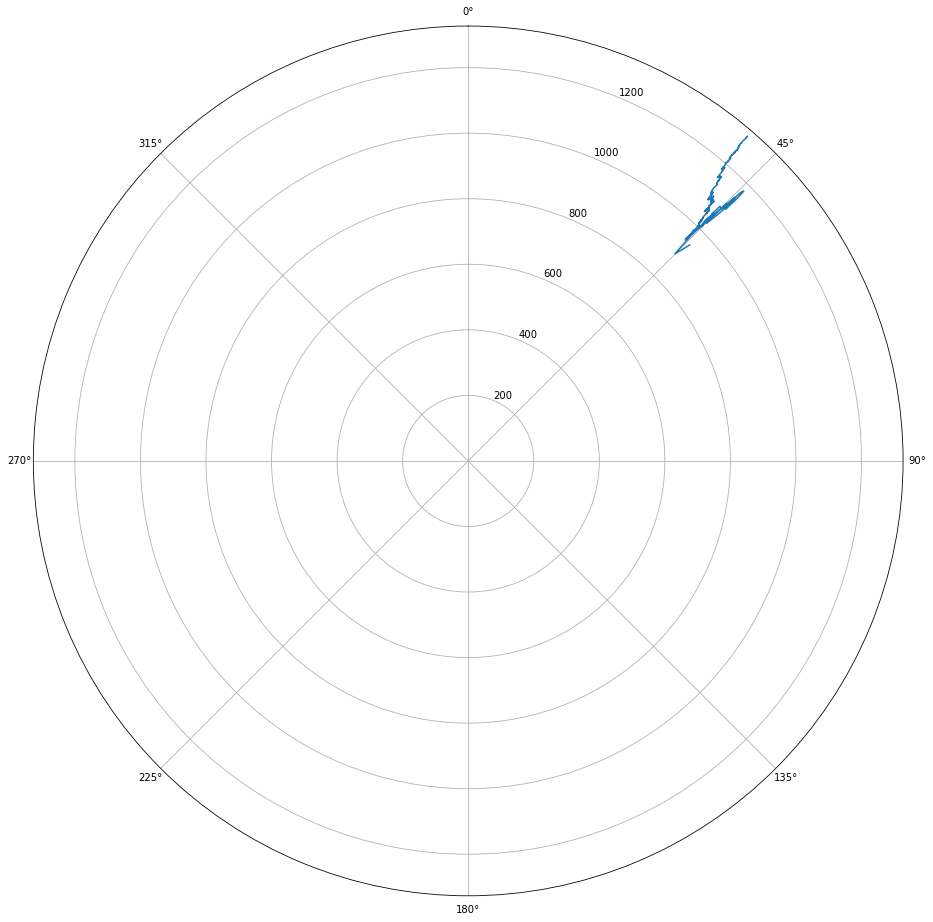

In [9]:
X_f1 = kalman_filt(data[1], X0[1], P0, F, Q, R)
plt.figure(figsize = (16, 8))
plt.plot(X_f1[0][:, 0], X_f1[0][:, 2])

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

plt.polar(X_f1[1][:, 1], X_f1[0][:, 0])

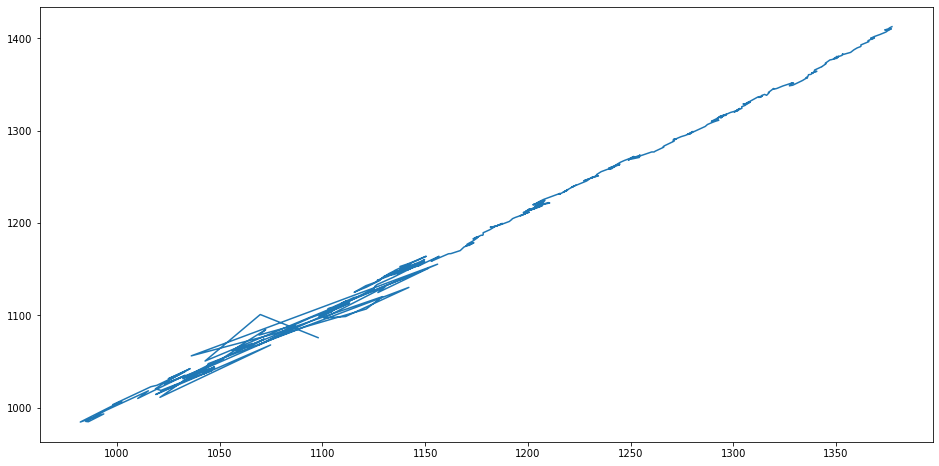

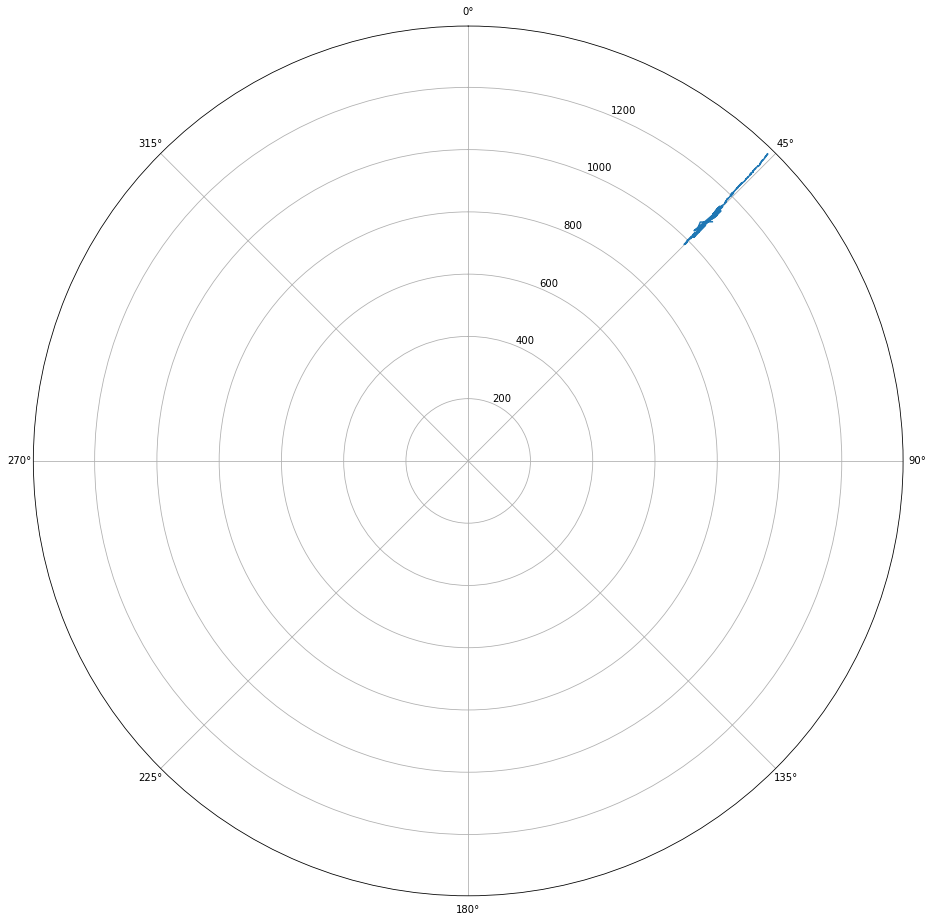

In [10]:
X_f2 = kalman_filt(data[2], X0[2], P0, F, Q, R)
plt.figure(figsize = (16, 8))
plt.plot(X_f2[0][:, 0], X_f2[0][:, 2])

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

plt.polar(X_f2[1][:, 1], X_f2[0][:, 0])

In [11]:
X_filt = X_f0, X_f1, X_f2

In [12]:
X_smooth = backward_smooth(X_filt[0][0], F, X_filt[0][3], X_filt[0][4]), backward_smooth(X_filt[1][0], F, X_filt[1][3], X_filt[1][4]), backward_smooth(X_filt[2][0], F, X_filt[2][3], X_filt[2][4])

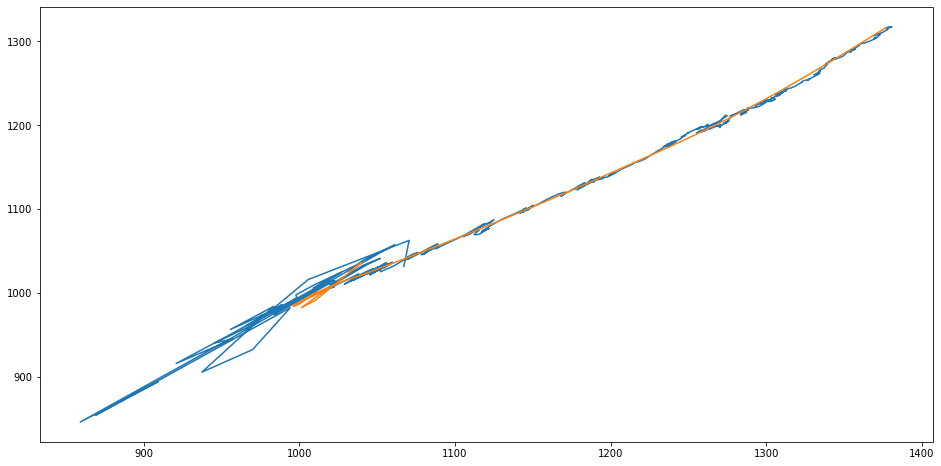

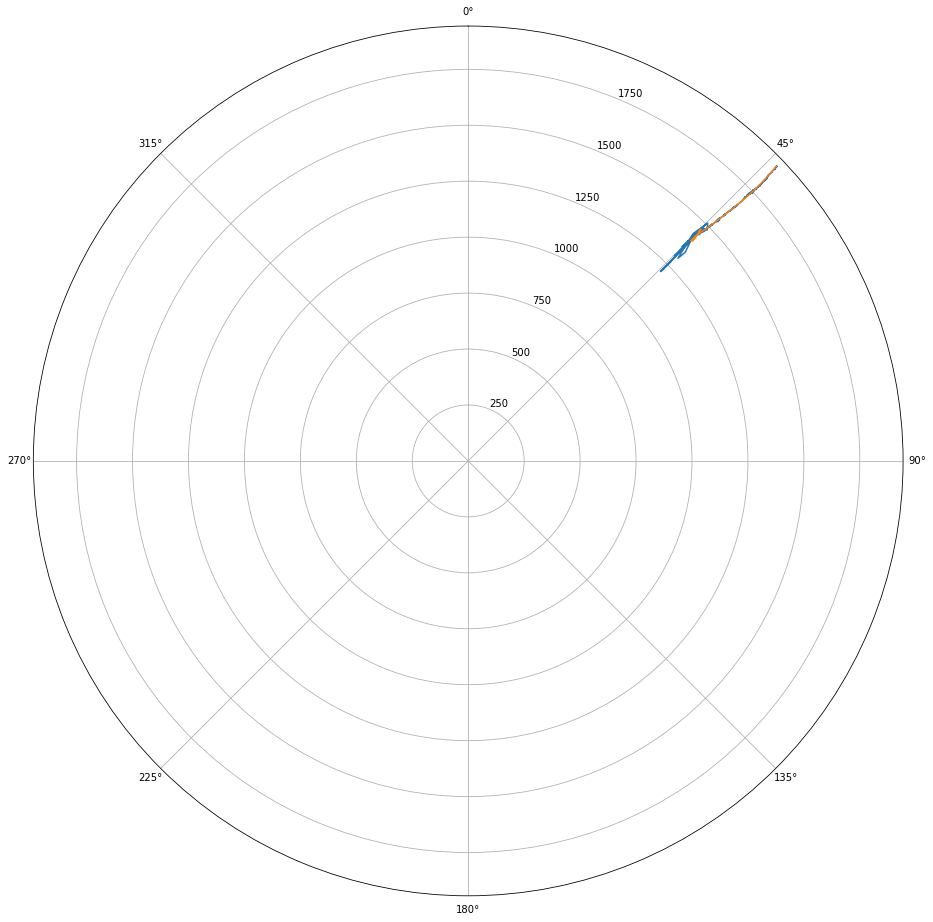

In [13]:
plt.figure(figsize = (16, 8))

plt.plot(X_filt[0][0][:, 0], X_filt[0][0][:, 2])
plt.plot(X_smooth[0][0][:, 0], X_smooth[0][0][:, 2])

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

plt.polar(X_filt[0][1][:, 1], X_filt[0][1][:, 0])
plt.polar(X_smooth[0][1][:, 1], X_smooth[0][1][:, 0])

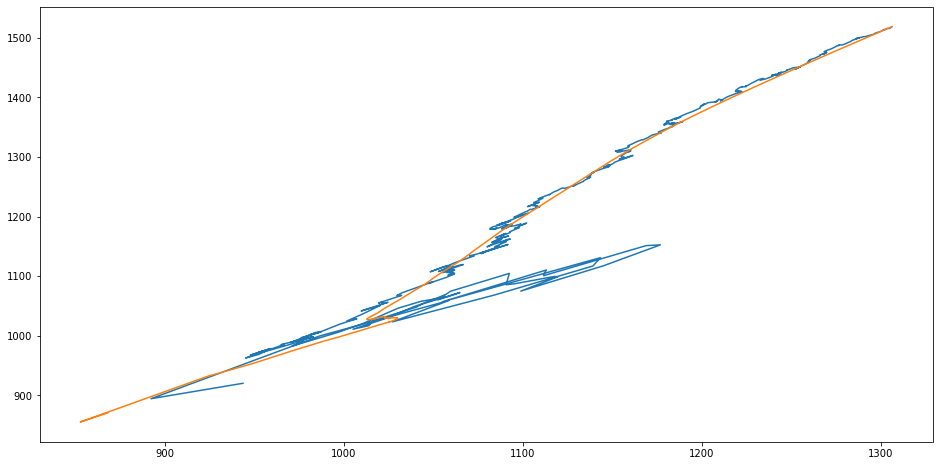

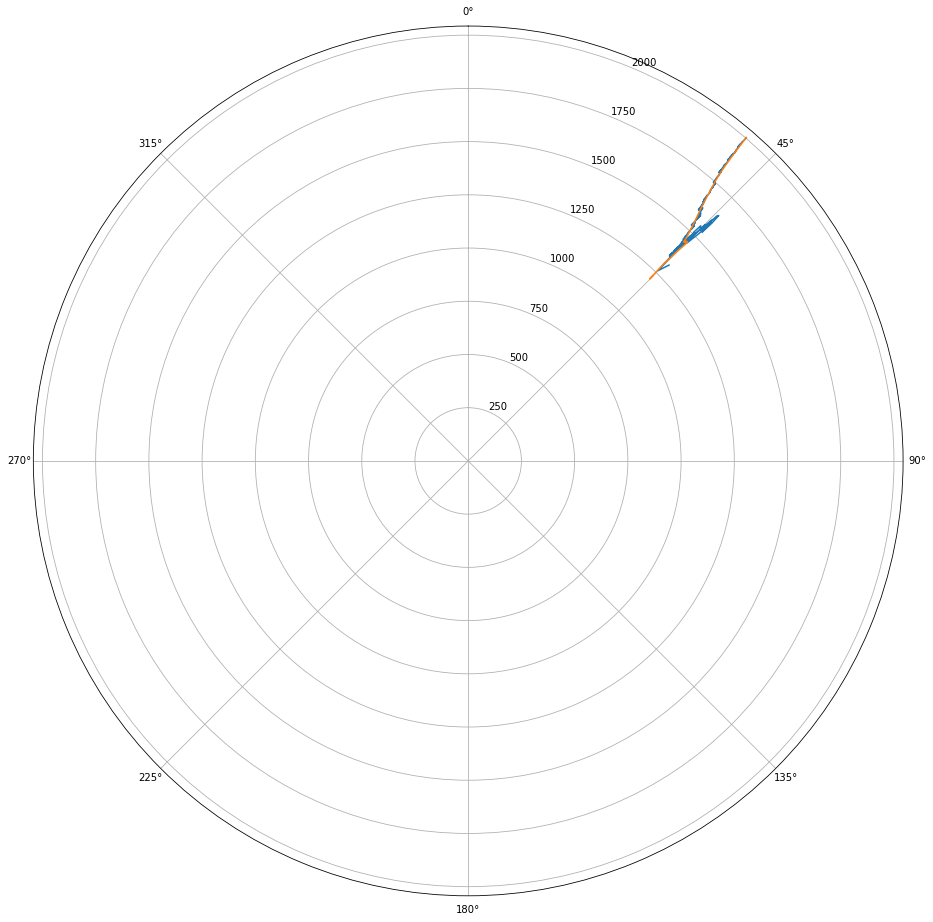

In [14]:
plt.figure(figsize = (16, 8))

plt.plot(X_filt[1][0][:, 0], X_filt[1][0][:, 2])
plt.plot(X_smooth[1][0][:, 0], X_smooth[1][0][:, 2])

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

plt.polar(X_filt[1][1][:, 1], X_filt[1][1][:, 0])
plt.polar(X_smooth[1][1][:, 1], X_smooth[1][1][:, 0])

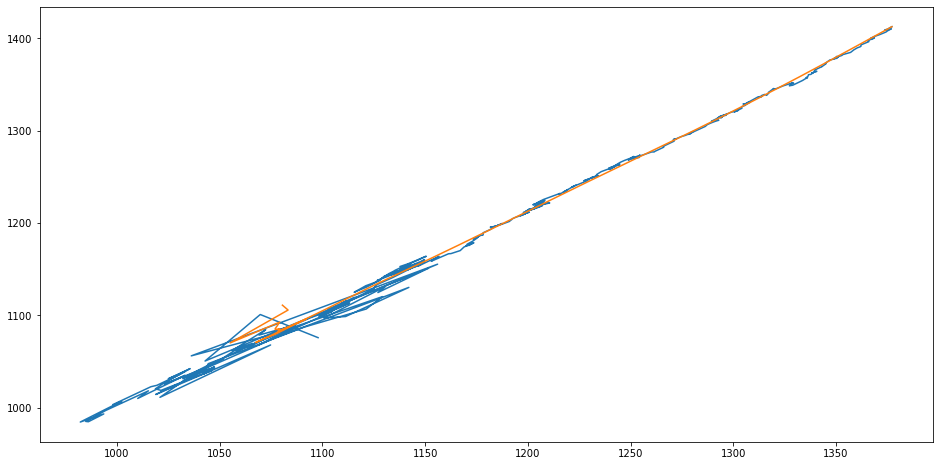

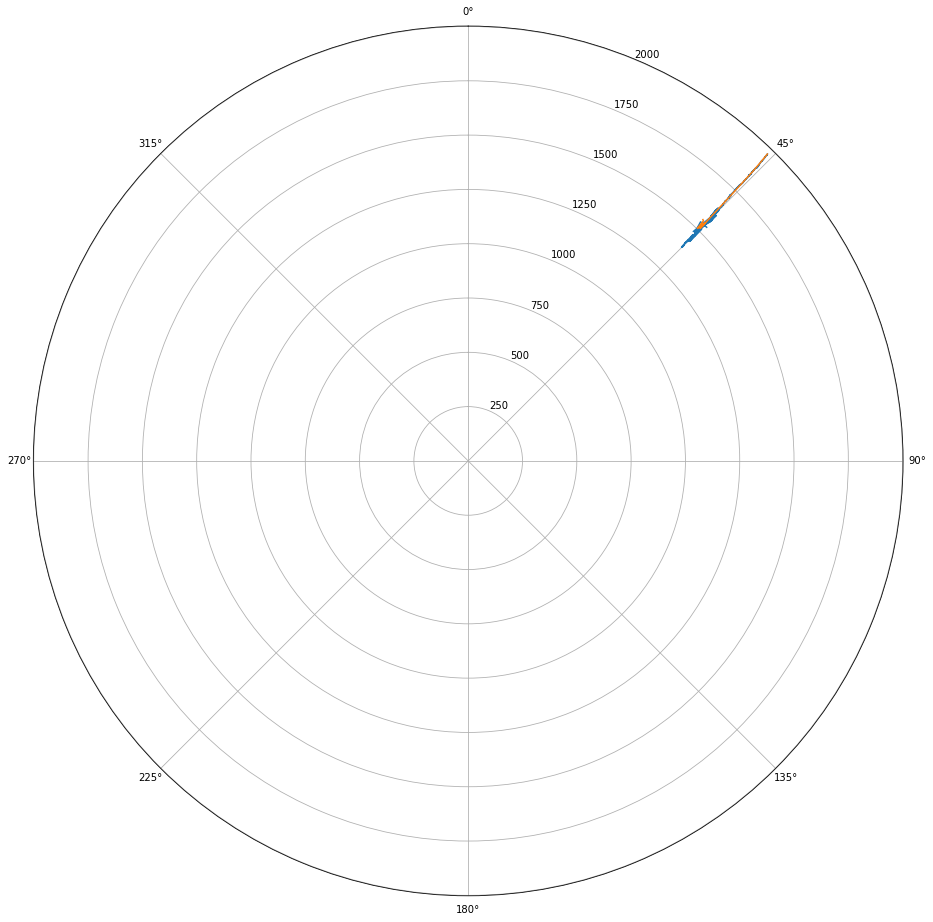

In [15]:
plt.figure(figsize = (16, 8))

plt.plot(X_filt[2][0][:, 0], X_filt[2][0][:, 2])
plt.plot(X_smooth[2][0][:, 0], X_smooth[2][0][:, 2])

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

plt.polar(X_filt[2][1][:, 1], X_filt[2][1][:, 0])
plt.polar(X_smooth[2][1][:, 1], X_smooth[2][1][:, 0])

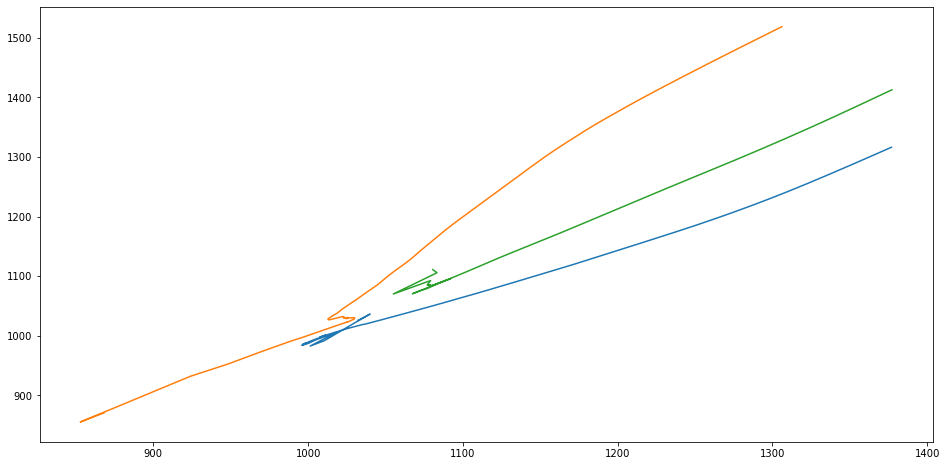

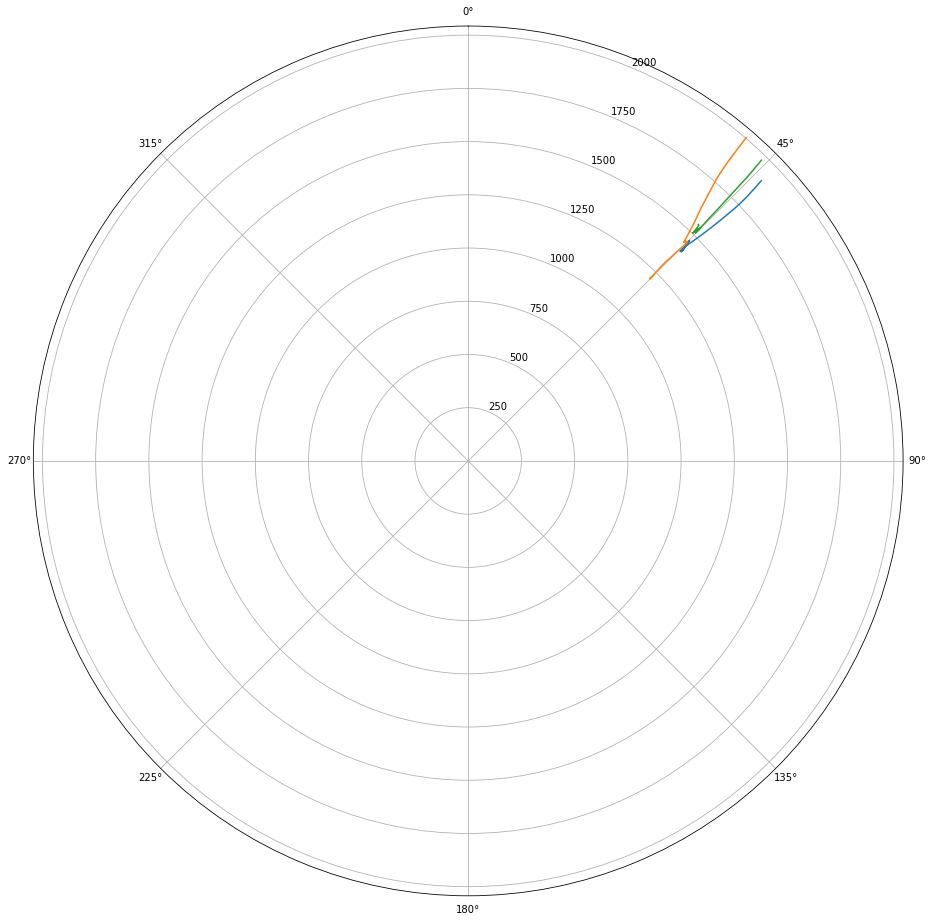

In [16]:
plt.figure(figsize = (16, 8))

plt.plot(X_smooth[0][0][:, 0], X_smooth[0][0][:, 2])
plt.plot(X_smooth[1][0][:, 0], X_smooth[1][0][:, 2])
plt.plot(X_smooth[2][0][:, 0], X_smooth[2][0][:, 2])

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

plt.polar(X_smooth[0][1][:, 1], X_smooth[0][1][:, 0])
plt.polar(X_smooth[1][1][:, 1], X_smooth[1][1][:, 0])
plt.polar(X_smooth[2][1][:, 1], X_smooth[2][1][:, 0])

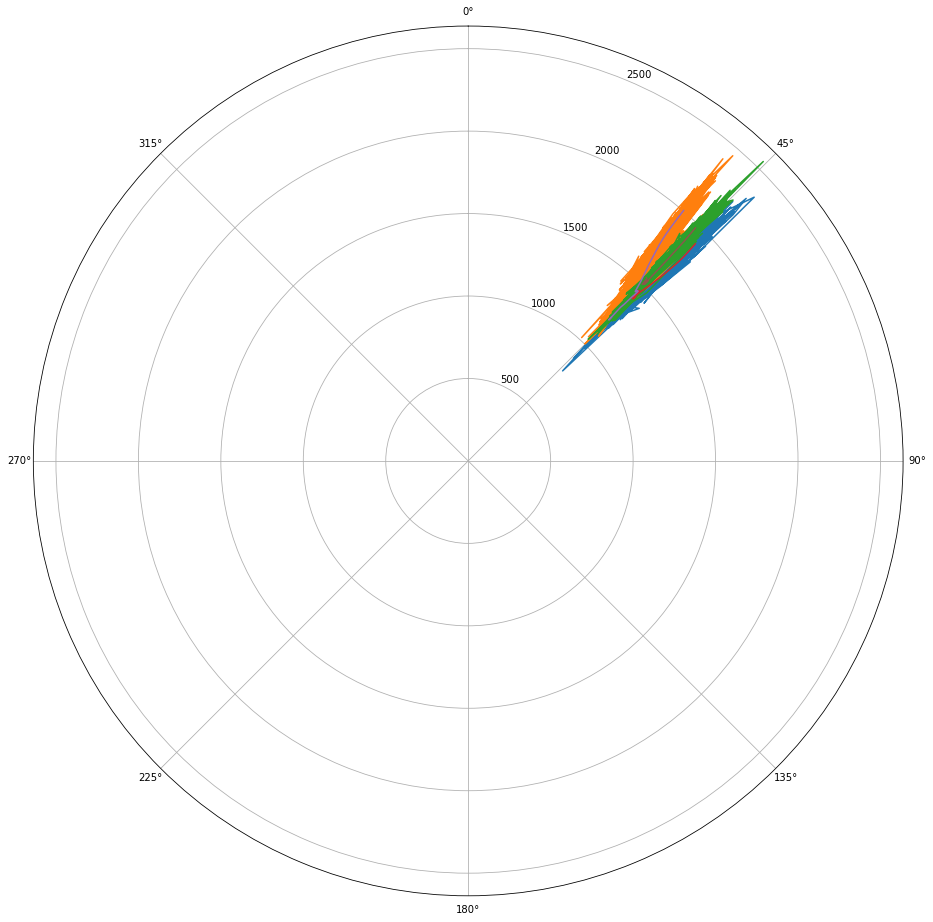

In [17]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

plt.plot(data[0][:, 1], data[0][:, 0])

plt.plot(data[1][:, 1], data[1][:, 0])

plt.polar(data[2][:, 1], data[2][:, 0])

plt.polar(X_smooth[0][1][:, 1], X_smooth[0][1][:, 0])
plt.polar(X_smooth[1][1][:, 1], X_smooth[1][1][:, 0])
plt.polar(X_smooth[2][1][:, 1], X_smooth[2][1][:, 0])